In [71]:
import numpy
import pandas as pd
data = pd.read_excel ( 'Station_2.xlsx')

In [72]:
df1 = data.replace(to_replace = '-', value = numpy.nan) 

In [73]:
df = df1.interpolate(method ='linear', direction = 'foreward')
df.columns.values

array(['Unnamed: 0', 'Date', 7013, 7032, 7042, 7082, 7112, 7122, 7132,
       7142, 7152, 7162, 7182, 7242, 7252, 7262, 7282, 7341, 7391, 7472,
       7480, 7502, 7530, 7540, 7550, 7670, 7702, 7714, 7731, 7751, 7760,
       7770, 7780, 7800, 7810, 17022, 17052, 17062, 171181], dtype=object)

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import math

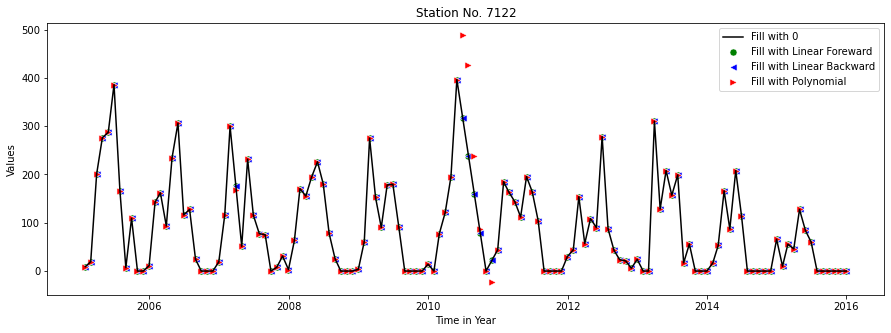

In [75]:
x=df['Date']
y0 = data[7122].replace(to_replace = '-', value = 0)
yP = y0.interpolate(method ='polynomial', order =2)
yLf = y0.interpolate(method ='linear', direction = 'forward')
yLb = y0.interpolate(method ='linear', direction = 'backward')

plt.figure(figsize=(15,5))

plt.xlabel('Time in Year')
plt.ylabel('Values')
plt.title('Station No. 7122')

sns.lineplot(x=x,y=y0, color='black', label= 'Fill with 0')
sns.scatterplot(x=x,y=yLf , s= 50, marker = 'o', color='green', label= 'Fill with Linear Foreward')
sns.scatterplot(x=x,y=yLb, s= 50, marker = '<', color='blue', label= 'Fill with Linear Backward') 
sns.scatterplot(x=x,y=yP, s= 50, marker = '>', color='red', label= 'Fill with Polynomial') 

plt.legend()

In [76]:
#develop LSTM recurrent neural networks for time series prediction in Python with the Keras deep learning network.
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(yLf.values.reshape(-1,1)) #DATA#

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# split into train and test sets
train_size = int(len(dataset) * 0.70) #70% training data#
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
90/90 - 0s - loss: 0.0867
Epoch 2/100
90/90 - 0s - loss: 0.0594
Epoch 3/100
90/90 - 0s - loss: 0.0496
Epoch 4/100
90/90 - 0s - loss: 0.0466
Epoch 5/100
90/90 - 0s - loss: 0.0455
Epoch 6/100
90/90 - 0s - loss: 0.0446
Epoch 7/100
90/90 - 0s - loss: 0.0440
Epoch 8/100
90/90 - 0s - loss: 0.0435
Epoch 9/100
90/90 - 0s - loss: 0.0431
Epoch 10/100
90/90 - 0s - loss: 0.0427
Epoch 11/100
90/90 - 0s - loss: 0.0426
Epoch 12/100
90/90 - 0s - loss: 0.0423
Epoch 13/100
90/90 - 0s - loss: 0.0421
Epoch 14/100
90/90 - 0s - loss: 0.0420
Epoch 15/100
90/90 - 0s - loss: 0.0417
Epoch 16/100
90/90 - 0s - loss: 0.0414
Epoch 17/100
90/90 - 0s - loss: 0.0414
Epoch 18/100
90/90 - 0s - loss: 0.0413
Epoch 19/100
90/90 - 0s - loss: 0.0415
Epoch 20/100
90/90 - 0s - loss: 0.0414
Epoch 21/100
90/90 - 0s - loss: 0.0411
Epoch 22/100
90/90 - 0s - loss: 0.0414
Epoch 23/100
90/90 - 0s - loss: 0.0414
Epoch 24/100
90/90 - 0s - loss: 0.0413
Epoch 25/100
90/90 - 0s - loss: 0.0411
Epoch 26/100
90/90 - 0s - loss: 0.

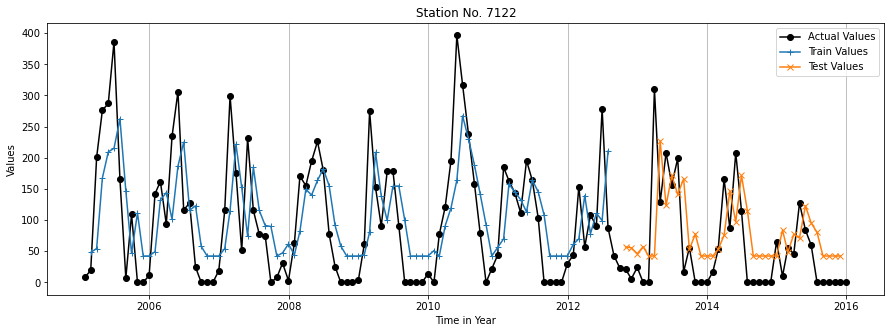

In [81]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(15,5))

plt.plot(df['Date'] , scaler.inverse_transform(dataset), c='black',marker = 'o', label= 'Actual Values')
plt.plot(df['Date'] ,trainPredictPlot, marker = '+',label= 'Train Values')
plt.plot(df['Date'] ,testPredictPlot, marker = 'x', label= 'Test Values')

plt.xlabel('Time in Year')
plt.ylabel('Values')
plt.title('Station No. 7122')
plt.grid(True, which = 'both', axis = 'x')
plt.legend()

In [84]:
#problem with window regression framing
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(yLf.values.reshape(-1,1))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 15 #The create_dataset() this formulation of the time series problem by increasing the look_back from 1 to 15.
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
76/76 - 0s - loss: 0.0942
Epoch 2/100
76/76 - 0s - loss: 0.0601
Epoch 3/100
76/76 - 0s - loss: 0.0493
Epoch 4/100
76/76 - 0s - loss: 0.0446
Epoch 5/100
76/76 - 0s - loss: 0.0408
Epoch 6/100
76/76 - 0s - loss: 0.0378
Epoch 7/100
76/76 - 0s - loss: 0.0355
Epoch 8/100
76/76 - 0s - loss: 0.0337
Epoch 9/100
76/76 - 0s - loss: 0.0324
Epoch 10/100
76/76 - 0s - loss: 0.0313
Epoch 11/100
76/76 - 0s - loss: 0.0305
Epoch 12/100
76/76 - 0s - loss: 0.0293
Epoch 13/100
76/76 - 0s - loss: 0.0286
Epoch 14/100
76/76 - 0s - loss: 0.0282
Epoch 15/100
76/76 - 0s - loss: 0.0276
Epoch 16/100
76/76 - 0s - loss: 0.0269
Epoch 17/100
76/76 - 0s - loss: 0.0264
Epoch 18/100
76/76 - 0s - loss: 0.0262
Epoch 19/100
76/76 - 0s - loss: 0.0261
Epoch 20/100
76/76 - 0s - loss: 0.0256
Epoch 21/100
76/76 - 0s - loss: 0.0249
Epoch 22/100
76/76 - 0s - loss: 0.0251
Epoch 23/100
76/76 - 0s - loss: 0.0245
Epoch 24/100
76/76 - 0s - loss: 0.0240
Epoch 25/100
76/76 - 0s - loss: 0.0240
Epoch 26/100
76/76 - 0s - loss: 0.

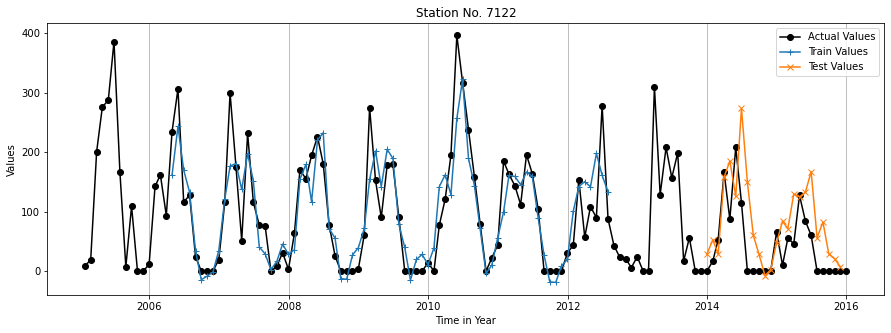

In [85]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(15,5))

plt.plot(df['Date'] , scaler.inverse_transform(dataset), c='black',marker = 'o', label= 'Actual Values')
plt.plot(df['Date'] ,trainPredictPlot, marker = '+',label= 'Train Values')
plt.plot(df['Date'] ,testPredictPlot, marker = 'x', label= 'Test Values')

plt.xlabel('Time in Year')
plt.ylabel('Values')
plt.title('Station No. 7122')
plt.grid(True, which = 'both', axis = 'x')
plt.legend()

In [86]:
#problem with time step regression framing

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(yLf.values.reshape(-1,1))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
72/72 - 0s - loss: 0.0602
Epoch 2/100
72/72 - 0s - loss: 0.0570
Epoch 3/100
72/72 - 0s - loss: 0.0556
Epoch 4/100
72/72 - 0s - loss: 0.0542
Epoch 5/100
72/72 - 0s - loss: 0.0532
Epoch 6/100
72/72 - 0s - loss: 0.0515
Epoch 7/100
72/72 - 0s - loss: 0.0495
Epoch 8/100
72/72 - 0s - loss: 0.0488
Epoch 9/100
72/72 - 0s - loss: 0.0479
Epoch 10/100
72/72 - 0s - loss: 0.0475
Epoch 11/100
72/72 - 0s - loss: 0.0462
Epoch 12/100
72/72 - 0s - loss: 0.0457
Epoch 13/100
72/72 - 0s - loss: 0.0445
Epoch 14/100
72/72 - 0s - loss: 0.0440
Epoch 15/100
72/72 - 0s - loss: 0.0434
Epoch 16/100
72/72 - 0s - loss: 0.0423
Epoch 17/100
72/72 - 0s - loss: 0.0419
Epoch 18/100
72/72 - 0s - loss: 0.0425
Epoch 19/100
72/72 - 0s - loss: 0.0407
Epoch 20/100
72/72 - 0s - loss: 0.0396
Epoch 21/100
72/72 - 0s - loss: 0.0393
Epoch 22/100
72/72 - 0s - loss: 0.0388
Epoch 23/100
72/72 - 0s - loss: 0.0381
Epoch 24/100
72/72 - 0s - loss: 0.0379
Epoch 25/100
72/72 - 0s - loss: 0.0381
Epoch 26/100
72/72 - 0s - loss: 0.

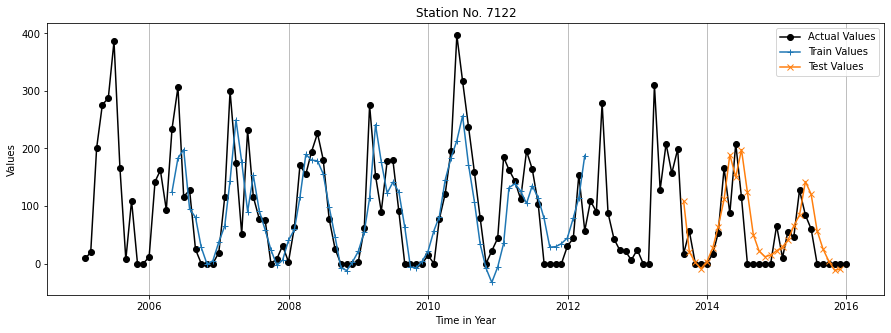

In [87]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(15,5))

plt.plot(df['Date'] , scaler.inverse_transform(dataset), c='black',marker = 'o', label= 'Actual Values')
plt.plot(df['Date'] ,trainPredictPlot, marker = '+',label= 'Train Values')
plt.plot(df['Date'] ,testPredictPlot, marker = 'x', label= 'Test Values')

plt.xlabel('Time in Year')
plt.ylabel('Values')
plt.title('Station No. 7122')
plt.grid(True, which = 'both', axis = 'x')
plt.legend()

In [88]:
#problem with Memory Between Batches

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(yLf.values.reshape(-1,1))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

72/72 - 0s - loss: 0.1351
72/72 - 0s - loss: 0.0833
72/72 - 0s - loss: 0.0645
72/72 - 0s - loss: 0.0583
72/72 - 0s - loss: 0.0561
72/72 - 0s - loss: 0.0547
72/72 - 0s - loss: 0.0534
72/72 - 0s - loss: 0.0520
72/72 - 0s - loss: 0.0504
72/72 - 0s - loss: 0.0485
72/72 - 0s - loss: 0.0463
72/72 - 0s - loss: 0.0439
72/72 - 0s - loss: 0.0415
72/72 - 0s - loss: 0.0390
72/72 - 0s - loss: 0.0367
72/72 - 0s - loss: 0.0346
72/72 - 0s - loss: 0.0327
72/72 - 0s - loss: 0.0312
72/72 - 0s - loss: 0.0300
72/72 - 0s - loss: 0.0291
72/72 - 0s - loss: 0.0285
72/72 - 0s - loss: 0.0281
72/72 - 0s - loss: 0.0278
72/72 - 0s - loss: 0.0276
72/72 - 0s - loss: 0.0274
72/72 - 0s - loss: 0.0273
72/72 - 0s - loss: 0.0272
72/72 - 0s - loss: 0.0272
72/72 - 0s - loss: 0.0271
72/72 - 0s - loss: 0.0270
72/72 - 0s - loss: 0.0270
72/72 - 0s - loss: 0.0269
72/72 - 0s - loss: 0.0268
72/72 - 0s - loss: 0.0268
72/72 - 0s - loss: 0.0267
72/72 - 0s - loss: 0.0267
72/72 - 0s - loss: 0.0266
72/72 - 0s - loss: 0.0266
72/72 - 0s -

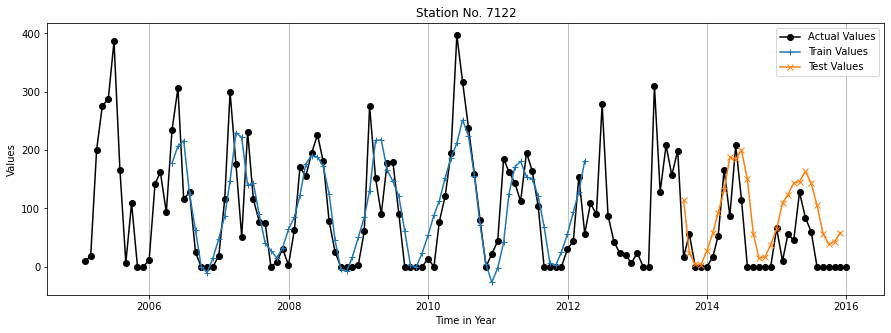

In [89]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(15,5))

plt.plot(df['Date'] , scaler.inverse_transform(dataset), c='black',marker = 'o', label= 'Actual Values')
plt.plot(df['Date'] ,trainPredictPlot, marker = '+',label= 'Train Values')
plt.plot(df['Date'] ,testPredictPlot, marker = 'x', label= 'Test Values')

plt.xlabel('Time in Year')
plt.ylabel('Values')
plt.title('Station No. 7122')
plt.grid(True, which = 'both', axis = 'x')
plt.legend()

In [90]:
#Stacked LSTMs with Memory Between Batches

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(yLf.values.reshape(-1,1))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

72/72 - 1s - loss: 0.0901
72/72 - 1s - loss: 0.0611
72/72 - 1s - loss: 0.0594
72/72 - 1s - loss: 0.0589
72/72 - 1s - loss: 0.0582
72/72 - 1s - loss: 0.0573
72/72 - 1s - loss: 0.0558
72/72 - 1s - loss: 0.0527
72/72 - 1s - loss: 0.0461
72/72 - 1s - loss: 0.0381
72/72 - 1s - loss: 0.0339
72/72 - 1s - loss: 0.0321
72/72 - 1s - loss: 0.0311
72/72 - 1s - loss: 0.0304
72/72 - 1s - loss: 0.0298
72/72 - 1s - loss: 0.0294
72/72 - 1s - loss: 0.0290
72/72 - 1s - loss: 0.0286
72/72 - 1s - loss: 0.0283
72/72 - 1s - loss: 0.0280
72/72 - 1s - loss: 0.0277
72/72 - 1s - loss: 0.0275
72/72 - 1s - loss: 0.0273
72/72 - 1s - loss: 0.0271
72/72 - 1s - loss: 0.0269
72/72 - 1s - loss: 0.0267
72/72 - 1s - loss: 0.0265
72/72 - 1s - loss: 0.0263
72/72 - 1s - loss: 0.0261
72/72 - 1s - loss: 0.0260
72/72 - 1s - loss: 0.0258
72/72 - 1s - loss: 0.0257
72/72 - 1s - loss: 0.0255
72/72 - 1s - loss: 0.0254
72/72 - 1s - loss: 0.0253
72/72 - 1s - loss: 0.0251
72/72 - 1s - loss: 0.0250
72/72 - 1s - loss: 0.0249
72/72 - 1s -

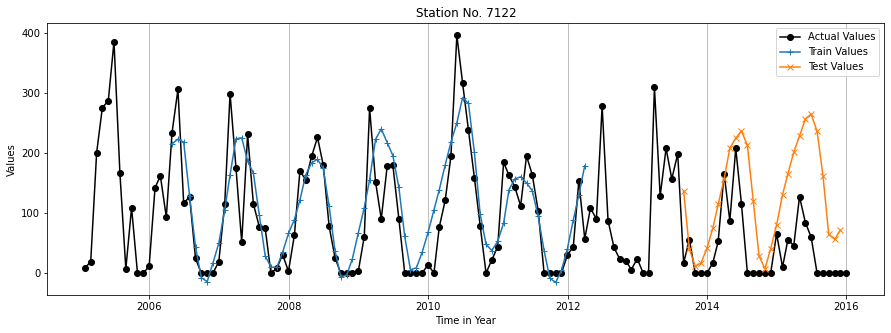

In [91]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(15,5))

plt.plot(df['Date'] , scaler.inverse_transform(dataset), c='black',marker = 'o', label= 'Actual Values')
plt.plot(df['Date'] ,trainPredictPlot, marker = '+',label= 'Train Values')
plt.plot(df['Date'] ,testPredictPlot, marker = 'x', label= 'Test Values')

plt.xlabel('Time in Year')
plt.ylabel('Values')
plt.title('Station No. 7122')
plt.grid(True, which = 'both', axis = 'x')
plt.legend()

In [ ]:
#Conclusion 
#LSTM for Regression Using the Window Method gives the best results
